In [1]:
!pip install numba==0.58.1
!pip install clifford
!pip install "numpy<2.0" numba==0.58.1

import clifford as cf

layout, blades = cf.Cl(3)

e1 = blades['e1']
e2 = blades['e2']
e3 = blades['e3']
e12 = blades['e12']
e13 = blades['e13']
e23 = blades['e23']
e123 = blades['e123']

  Using cached clifford-1.4.0-py3-none-any.whl.metadata (5.1 kB)
Using cached clifford-1.4.0-py3-none-any.whl (159 kB)


Calculating B-field magnitude over one period at specified points...
  - Processing point: Center (0, 0, 0)


/usr/local/lib/python3.11/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.11/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


  - Processing point: Off-axis (x=R/2, 0, 0)
  - Processing point: Off-axis (0, y=R/2, z=R/2)


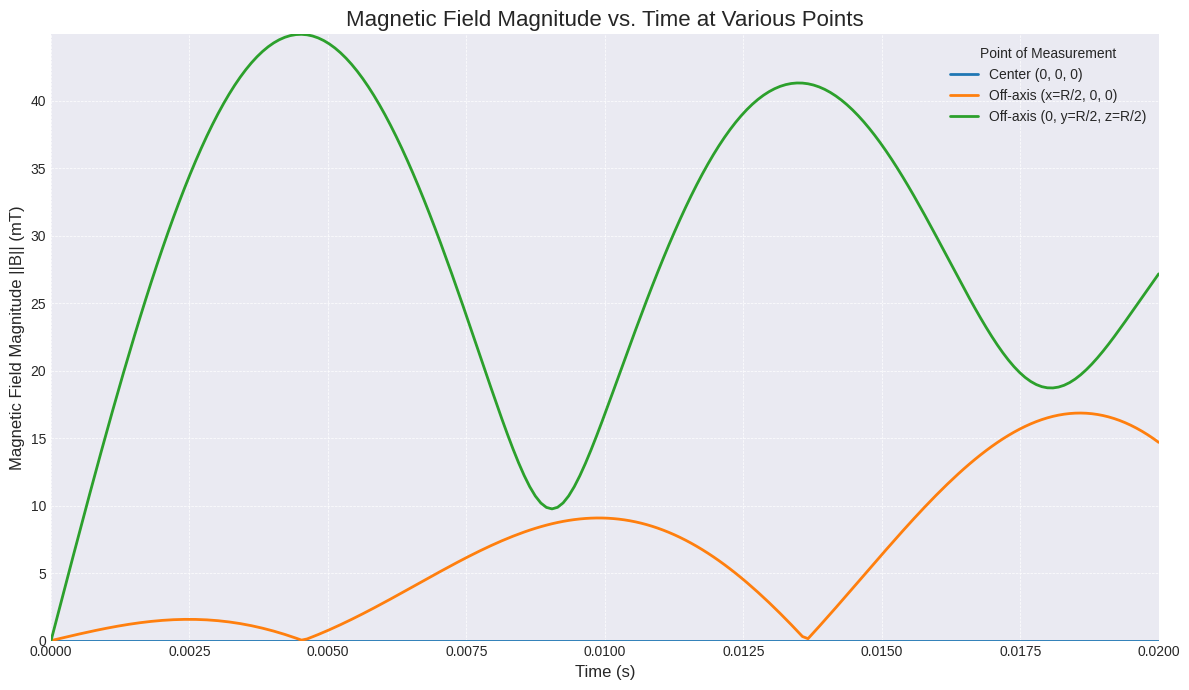

In [14]:
# It's good practice to install specific versions for reproducibility
# !pip install numba==0.58.1
# !pip install clifford
# !pip install "numpy<2.0"
# !pip install matplotlib scipy

import clifford as cf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from math import tau, sqrt

# --- Clifford Algebra Setup ---
# We are working in 3D Euclidean space, GA(3,0,0)
layout, blades = cf.Cl(3)
e1, e2, e3 = blades['e1'], blades['e2'], blades['e3']
e12, e13, e23 = blades['e12'], blades['e13'], blades['e23']

# --- Physical Constants ---
MU_0 = 2e-7 * tau  # Vacuum permeability in H/m

class Coil:
    """
    Represents a general circular coil of wire and calculates its magnetic field.

    The calculations are performed using Geometric Algebra, where the magnetic
    field B is represented as a bivector. The coil can be arbitrarily positioned
    (via 'center') and oriented (via 'rotor') in space.
    """

    def __init__(self, center, radius, turns, current_amplitude, frequency, phase=0.0, rotor=np.e**(-e23)):
        """
        Initializes the Coil object.

        Args:
            center (layout.MultiVector): The position vector of the coil's center.
            radius (float): The radius of the coil in meters.
            turns (int): The number of turns in the coil.
            current_amplitude (float): The peak current (I_max) in Amperes.
                                       A negative value reverses the current direction.
            frequency (float): The angular frequency (ω) of the AC current in rad/s.
            phase (float): The phase offset (φ) of the current in radians.
            rotor (layout.MultiVector): The rotor describing the coil's orientation.
                                        Defaults to 1.0 (no rotation), keeping the coil
                                        in the xy-plane.
        """
        self.center = center
        self.radius = radius
        self.turns = turns
        self.I_max = current_amplitude
        self.omega = frequency
        self.phase = phase
        self.rotor = rotor
        self.inv_rotor = ~self.rotor  # The inverse of a rotor is its reverse

    def _current(self, t):
        """Calculates the instantaneous current I(t) at time t."""
        return self.I_max * np.sin(self.omega * t + self.phase)

    def _local_position_vector(self, angle):
        """
        Calculates the position vector (r') of an element on the coil in its
        own reference frame (centered at the origin, in the xy-plane).
        """
        return self.radius * (np.cos(angle) * e1 + np.sin(angle) * e2)

    def _local_differential_vector(self, angle):
        """
        Calculates the differential line element (dl') for the coil element
        in its own reference frame.
        """
        return self.radius * (-np.sin(angle) * e1 + np.cos(angle) * e2)

    def B_differential(self, point_r, t, angle):
        """
        Calculates the differential magnetic field bivector (dB) from a coil element.

        This implements the Biot-Savart Law in Geometric Algebra form:
        dB = (μ₀ * N * I / 4π) * (dl' ∧ (r - r')) / |r - r'|³

        Args:
            point_r (layout.MultiVector): The point in space (r) to calculate the field at.
            t (float): The time at which to calculate the field.
            angle (float): The angle parameterizing the position on the coil loop.

        Returns:
            layout.MultiVector: The differential magnetic field bivector dB.
        """
        # 1. Get the local vectors for the coil element
        r_prime_local = self._local_position_vector(angle)
        dl_prime_local = self._local_differential_vector(angle)

        # 2. Rotate the local vectors to the coil's orientation in space
        r_prime_rotated = self.rotor * r_prime_local * self.inv_rotor
        dl_prime_rotated = self.rotor * dl_prime_local * self.inv_rotor

        # 3. Translate the rotated vector to the coil's final position
        r_prime_global = r_prime_rotated + self.center

        # 4. Apply the Biot-Savart Law
        distance_vec = point_r - r_prime_global
        dist_mag_cubed = abs(distance_vec)**3

        # Avoid division by zero if the point is exactly on the wire
        if dist_mag_cubed < 1e-15:
            return layout.MultiVector(value=np.zeros(layout.ga.SIZE))

        numerator = dl_prime_rotated ^ distance_vec
        constant = (MU_0 * self.turns * self._current(t)) / (4 * np.pi)

        return constant * numerator / dist_mag_cubed

    def B(self, point, t):
        """
        Calculates the total magnetic field bivector B at a point and time by
        numerically integrating the B_differential function over the entire coil.
        """
        # We need a lambda that takes a single argument for quad_vec
        func_to_integrate = lambda angle: self.B_differential(point, t, angle).value

        # Integrate from 0 to 2*pi
        integral_result, _ = quad_vec(func_to_integrate, 0, tau)

        return layout.MultiVector(value=integral_result)


if __name__ == '__main__':
    # --- Simulation Parameters ---
    R = 6.7e-2  # Radius of coils in meters
    I_AMP = 10.0  # Peak current in Amperes
    FREQ1 = 50.0 * tau  # Angular frequency in rad/s (e.g., 50 Hz)
    FREQ2 = 60.0 * tau  # Angular frequency in rad/s (e.g., 50 Hz)
    TURNS = 320 # Number of turns in each coil

    # --- Define the Four Coils for the Quadrupole ---
    # This setup now correctly implements the user's description.
    # We use translation ('center') and rotation ('rotor') independently.
    # To get opposing fields, we simply reverse the sign of the current.

    # Rotor to orient coils in the xz-plane (a 90-degree rotation around the y-axis)
    rotor_to_xz_plane = np.e**(-(tau / 8.0) * e23)

    coils = [
        # Coil 1: In xz-plane at z = -R/2, positive current
        Coil(center=-(R / 2.0) * e3, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=FREQ1),

        # Coil 2: In xz-plane at z = +R/2, negative current for opposing field
        Coil(center=(R / 2.0) * e3, radius=R, turns=TURNS, current_amplitude=-I_AMP, frequency=FREQ1),

        # Coil 3: In xz-plane at y = +R/2, positive current
        Coil(center=(R / 2.0) * e2, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=FREQ2, rotor=rotor_to_xz_plane),

        # Coil 4: In xz-plane at y = -R, negative current for opposing field
        Coil(center=-(R / 2.0) * e2, radius=R, turns=TURNS, current_amplitude=-I_AMP, frequency=FREQ2, rotor=rotor_to_xz_plane)
    ]

    # Define the points of interest for the time-domain analysis
    points_of_interest = {
        "Center (0, 0, 0)": 0*e1,
        "Off-axis (x=R/2, 0, 0)": (R/2) * e1,
        "Off-axis (0, y=R/2, z=R/2)": (R/2) * e2 + (R/2) * e3,
    }

    # Define time range for one full period of the current
    period = 1.0 / (FREQ / tau)
    t_space = np.linspace(0, period, 200) # 200 time steps for a smooth curve

    # Store results in a dictionary
    results = {name: [] for name in points_of_interest}

    print("Calculating B-field magnitude over one period at specified points...")
    for name, point in points_of_interest.items():
        print(f"  - Processing point: {name}")
        for t in t_space:
            # Sum the bivector fields from all four coils at this point and time
            B_total = sum(coil.B(point, t) for coil in coils)

            # The magnitude of a bivector B is sqrt(-B^2), given by abs() in clifford
            B_magnitude = abs(B_total)
            results[name].append(B_magnitude)

    # --- Plotting Results ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    for name, magnitudes in results.items():
        # Plot magnitude in milliTesla (mT) for better readability
        ax.plot(t_space, np.array(magnitudes) * 1000, label=name, lw=2)

    ax.set_title('Magnetic Field Magnitude vs. Time at Various Points', fontsize=16)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Magnetic Field Magnitude ||B|| (mT)', fontsize=12)
    ax.legend(title='Point of Measurement', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.autoscale(tight=True)
    ax.axhline(0, color='black', linewidth=0.5)

    plt.tight_layout()
    plt.show()